In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as mtick

In [7]:
from pyxel.models import BrokenPow
from astropy.modeling.powerlaws import PowerLaw1D
from astropy.modeling.functional_models import Const1D
from astropy.modeling.fitting import LevMarLSQFitter

Read the surface brightness profile from the text file. The profile is restricted to the radial range 100-330 arcmin (not much beyond 330 arcmin).

In [3]:
sb_file = "sb_n_07_2_100.txt"
with open(sb_file) as f:
    data = f.readlines()

rmin = 100.
rmax = 330.

# central radii of the bins
r = np.array([float(line.split()[0]) for line in data if rmin <= float(line.split()[0]) <= rmax])

# surface brightness 
sb = np.array([float(line.split()[1]) for line in data if rmin <= float(line.split()[0]) <= rmax])

# uncertainties on surface brightness
sb_err = np.array([float(line.split()[2]) for line in data if rmin <= float(line.split()[0]) <= rmax])

Plot the surface brightness profile to get an idea of what needs to be fitted to it.

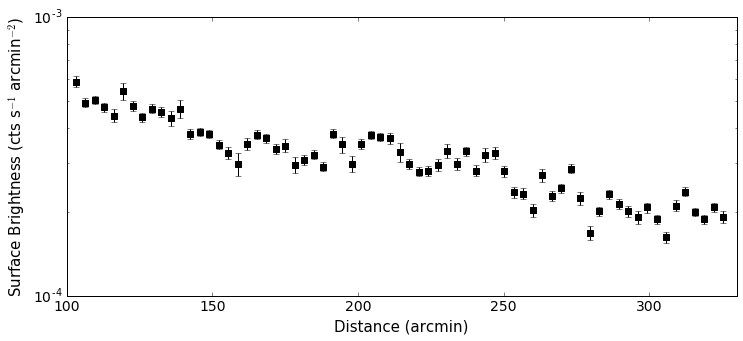

In [4]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.semilogy()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

Fit the background with a constant.

In [12]:
r0 = np.array([x for x in r if x > 275.])
sb0 = np.array([sb[i] for i in range(len(sb)) if r[i] > 275.])
sb0_err = np.array([sb_err[i] for i in range(len(sb_err)) if r[i] > 275.])
model0 = Const1D(amplitude=1.5e-4)

fit0 = LevMarLSQFitter()
fitted_model0 = fit0(model0, r0, sb0, weights=1./sb0_err, estimate_jacobian=True, maxiter=1000)
print(fitted_model0)

if fit0.fit_info['param_cov'] is not None:
    uncertainties = [np.sqrt(x) for x in fit0.fit_info['param_cov'].diagonal()]
    print('Parameter uncertainties (free params, if bounds not reached): \n', uncertainties)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude    
    -----------------
    0.000199727968915
Parameter uncertainties (free params, if bounds not reached): 
 [4.9738090552178434e-06]


Plot the background model.

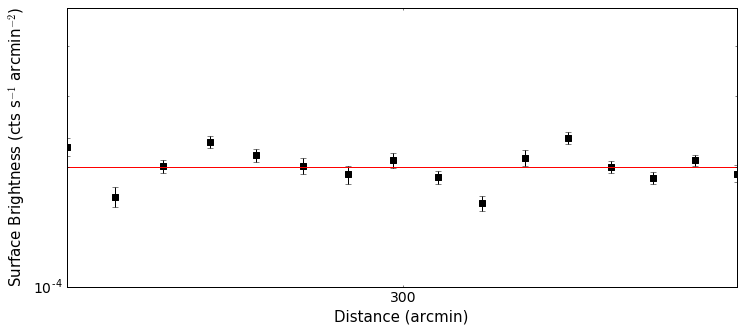

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))

plt.scatter(r0, sb0, s=30, marker='s', c="k")
plt.errorbar(r0, sb0, yerr=sb0_err, linestyle="None", c="k")
plt.plot(r0, fitted_model0(r0), c='r')

plt.xlim(np.min(r0), np.max(r0))
plt.ylim(1e-4, 5e-4)
plt.loglog()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

Fit the profile with a broken power-law model. By default, jump is restricted to [1, 4], because values outside this range don't make sense for a shock.

In [21]:
model1 = BrokenPow(ind1=1., ind2=1., norm=6e-4, rbreak=220., jump=1.5, const=2e-4)
model1.const.fixed = True
model1.rbreak.fixed = True

fit1 = LevMarLSQFitter()
fitted_model1 = fit1(model1, r, sb, weights=1./sb_err, estimate_jacobian=True, maxiter=1000)
print(fitted_model1)

# No uncertainties are printed, because the best-fitting value of the jump reaches the lower boundary.
if fit1.fit_info['param_cov'] is not None:
    uncertainties = [np.sqrt(x) for x in fit1.fit_info['param_cov'].diagonal()]
    print('Parameter uncertainties (free params, if bounds not reached): \n', uncertainties)

Model: BrokenPow
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         ind1           ind2            norm       rbreak jump const 
    -------------- ------------- ----------------- ------ ---- ------
    0.709234778275 3.29451012485 7.10987897666e-07  220.0  1.0 0.0002


Plot the best-fitting broken power-law model.

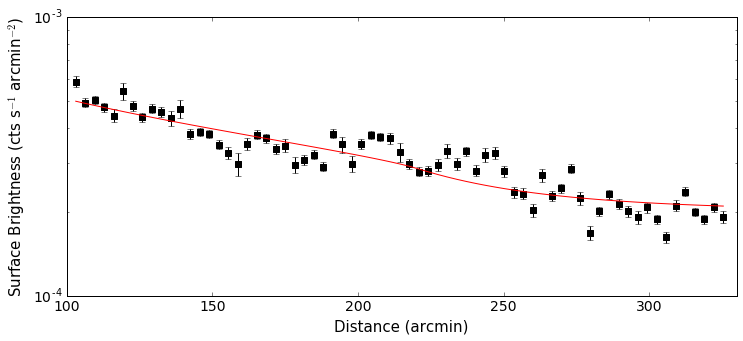

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")
plt.plot(r, fitted_model1(r), c='r')

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.semilogy()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

Fit the profile with a simple power-law.

In [29]:
model2 = PowerLaw1D(amplitude=3e-4, x_0=10., alpha=3.) + Const1D(amplitude=2e-4)
model2.x_0_0.fixed = True
model2.amplitude_1.fixed = True

fit2 = LevMarLSQFitter()
fitted_model2 = fit2(model2, r, sb, weights=1./sb_err, estimate_jacobian=True, maxiter=2000)
print(fitted_model2, '\n')

if fit2.fit_info['param_cov'] is not None:
    uncertainties = [np.sqrt(x) for x in fit2.fit_info['param_cov'].diagonal()]
    print('Parameter uncertainties (free params, if bounds not reached): \n', uncertainties)

Model: CompoundModel4
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <PowerLaw1D(amplitude=0.0003, x_0=10.0, alpha=3.0)>

    [1]: <Const1D(amplitude=0.0002)>
Parameters:
      amplitude_0   x_0_0    alpha_0    amplitude_1
    --------------- ----- ------------- -----------
    0.0883683419147  10.0 2.32107339301      0.0002 

Parameter uncertainties (free params, if bounds not reached): 
 [0.039958056412688278, 0.16818996927884455]


//anaconda/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: overflow encountered in power
  return amplitude * xx ** (-alpha)
//anaconda/lib/python3.5/site-packages/astropy/modeling/fitting.py:408: RuntimeWarning: overflow encountered in multiply
  return np.ravel(weights * (model(*args[2 : -1]) - meas))


Plot the best-fitting power-law.

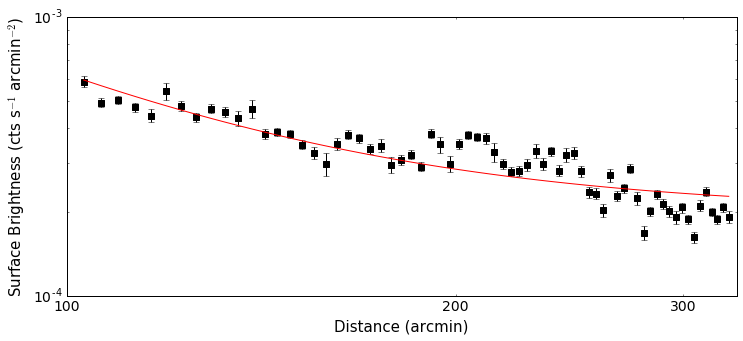

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))

plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")
plt.plot(r, fitted_model2(r), c='r')

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.loglog()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))